In [1]:
import sys
sys.path.append('..')

from utils import show
import image_processes as imgp
import map_processes as mapp
import utils as ut
import numpy as np
import cv2
import os
import numpy as np
from skimage.morphology import medial_axis
from skimage.util import invert
from skimage.io import imread
import json

%load_ext autoreload
%autoreload 2


In [2]:
imgName = 'map_tworivers_input.png'
projectName = 'tworivers'
texturePath = '../../../textures/maps/'
outputPath = '../../../outputs/'
outputPath = os.path.join(outputPath, projectName)

imgPath = os.path.join(texturePath, imgName)
# gray to get the height and width with shape
image = imread(imgPath, as_gray=True)
height, width = image.shape

# imgSize = (int(width/8), int(height/8))
imgSize = (width, height)
image = cv2.resize(image, imgSize)

if not os.path.exists(outputPath):
    os.makedirs(outputPath)

inputPath = os.path.join(outputPath, 'input.png')
cv2.imwrite(inputPath, cv2.cvtColor(imread(imgPath), cv2.COLOR_BGR2RGB))


def getPath(filename):
    return os.path.join(outputPath, filename)

In [3]:
image = cv2.imread(imgPath)
image = cv2.resize(image, imgSize)
imgp.convertToRGB(image, False);

In [4]:
gray = imgp.convertToGray(image, False)

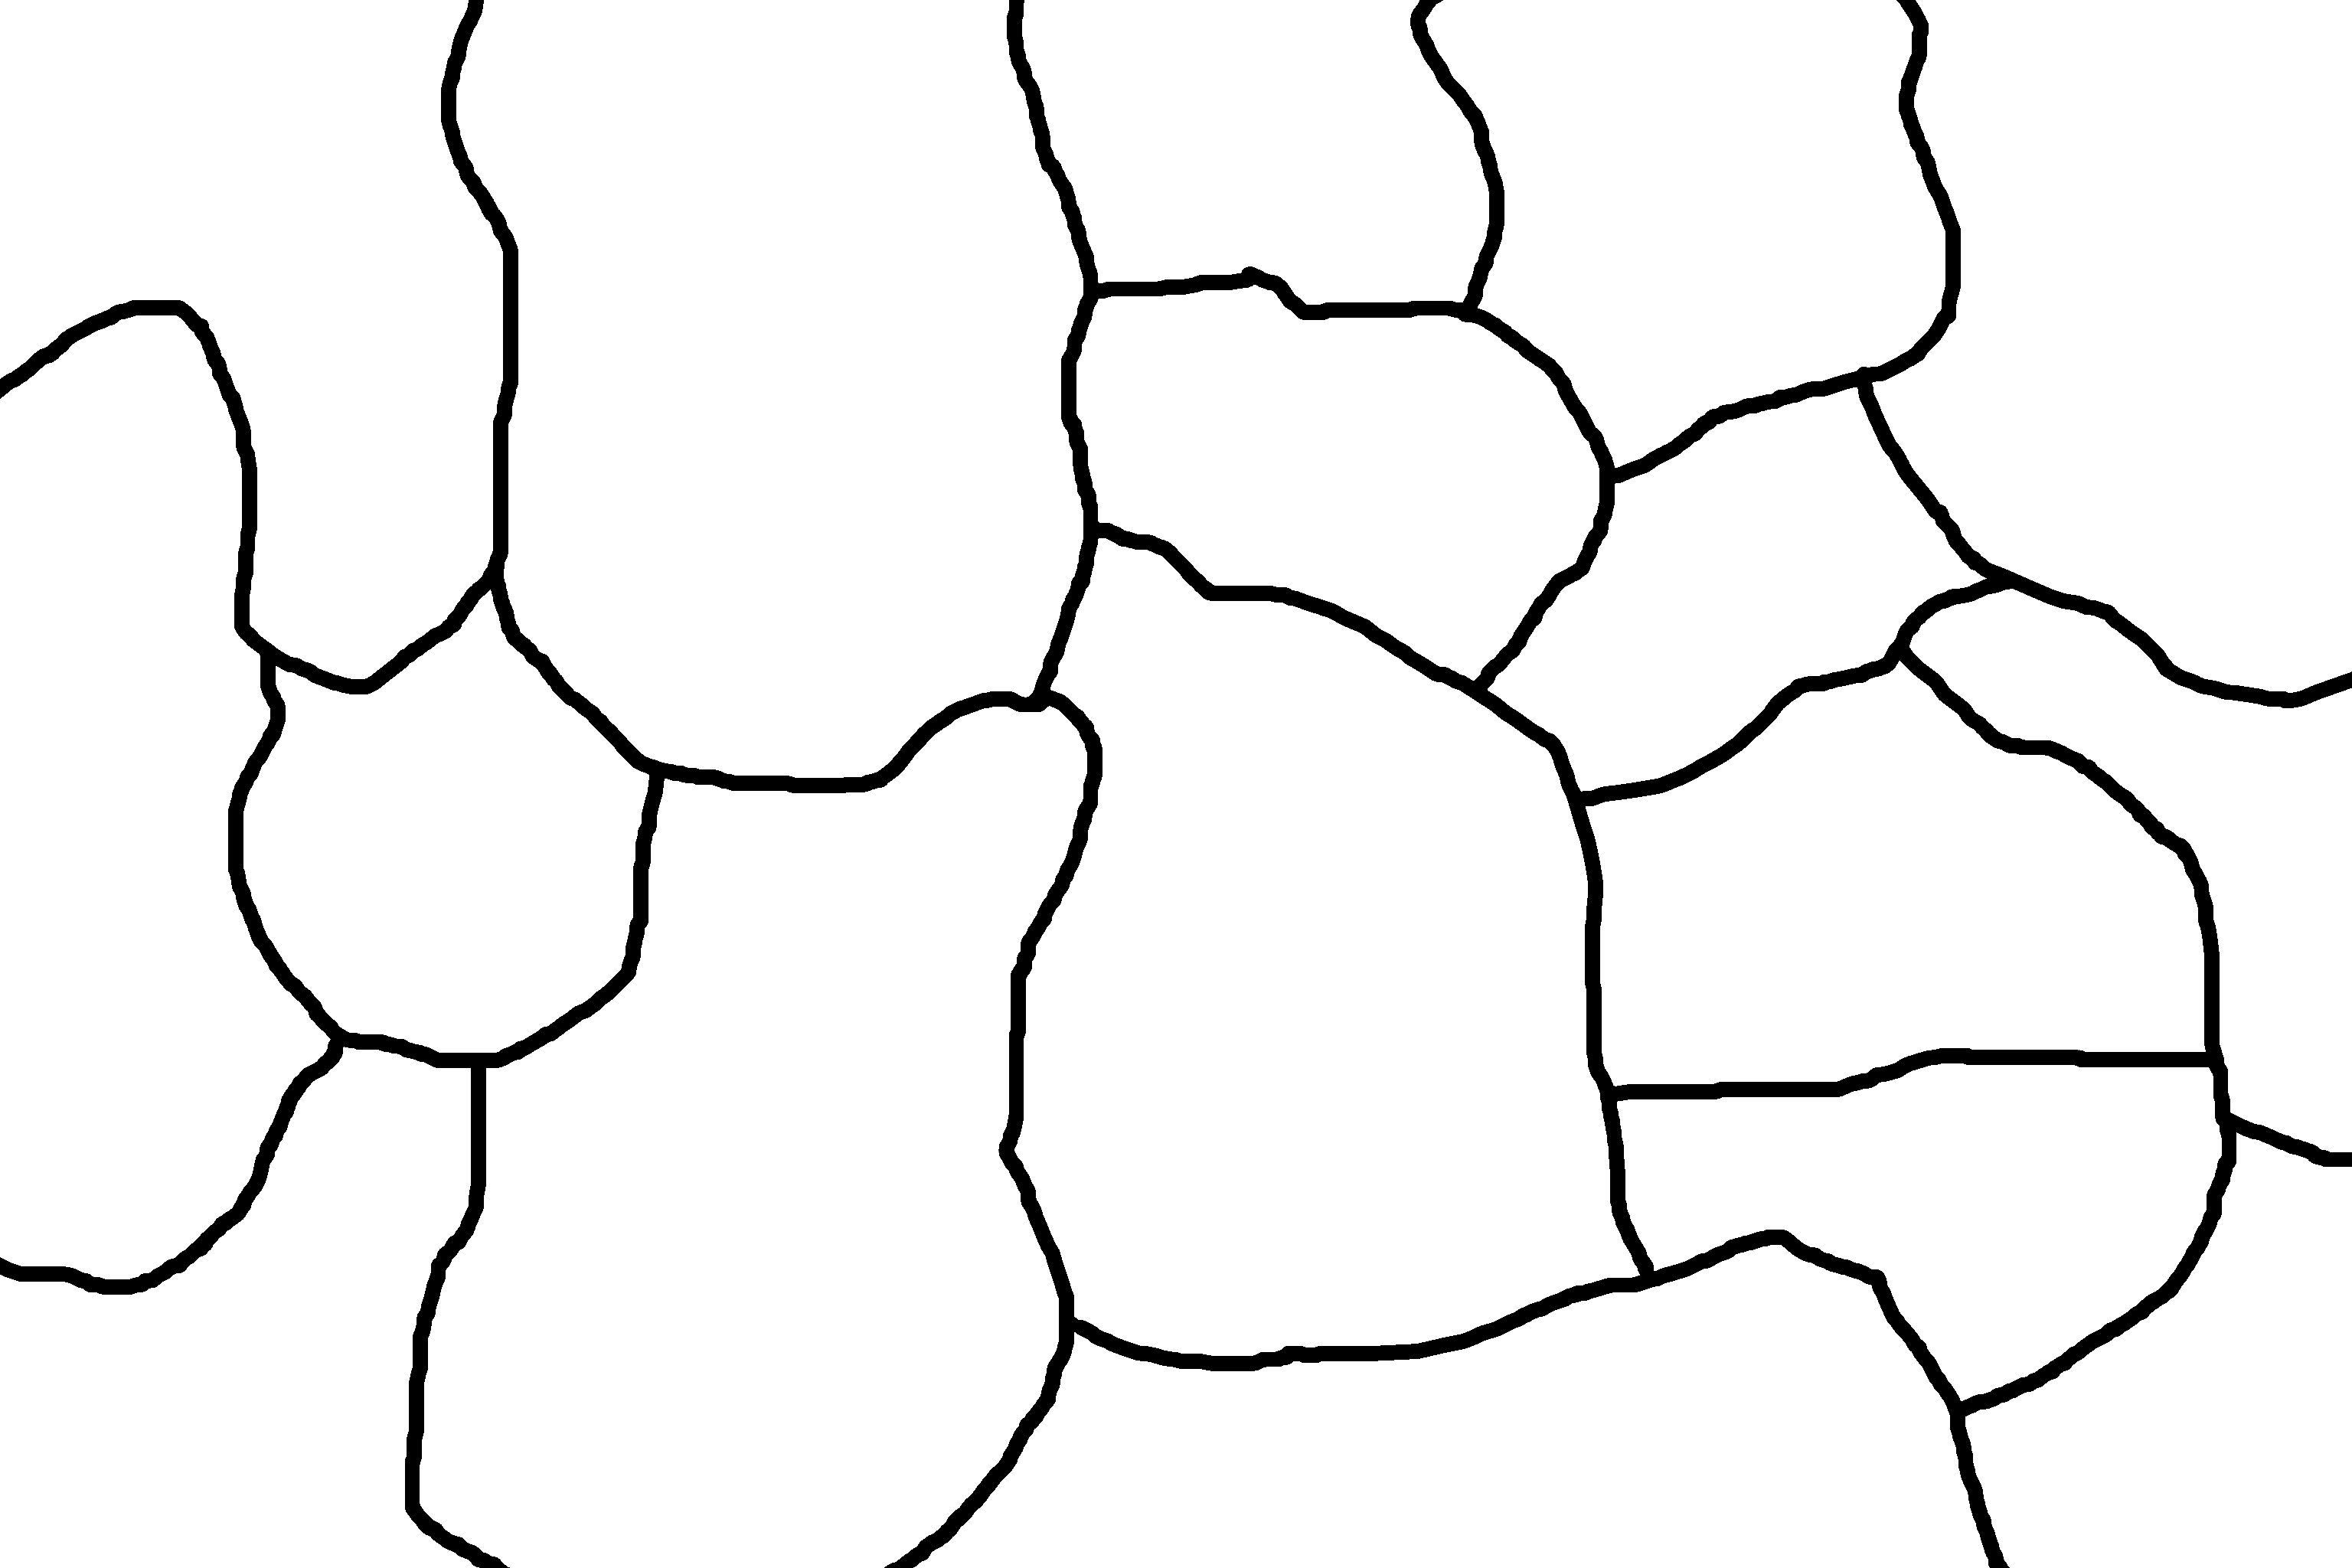

In [5]:
# Threshold
grayThreshold = 100
thresholded = imgp.threshold(gray, grayThreshold, True)

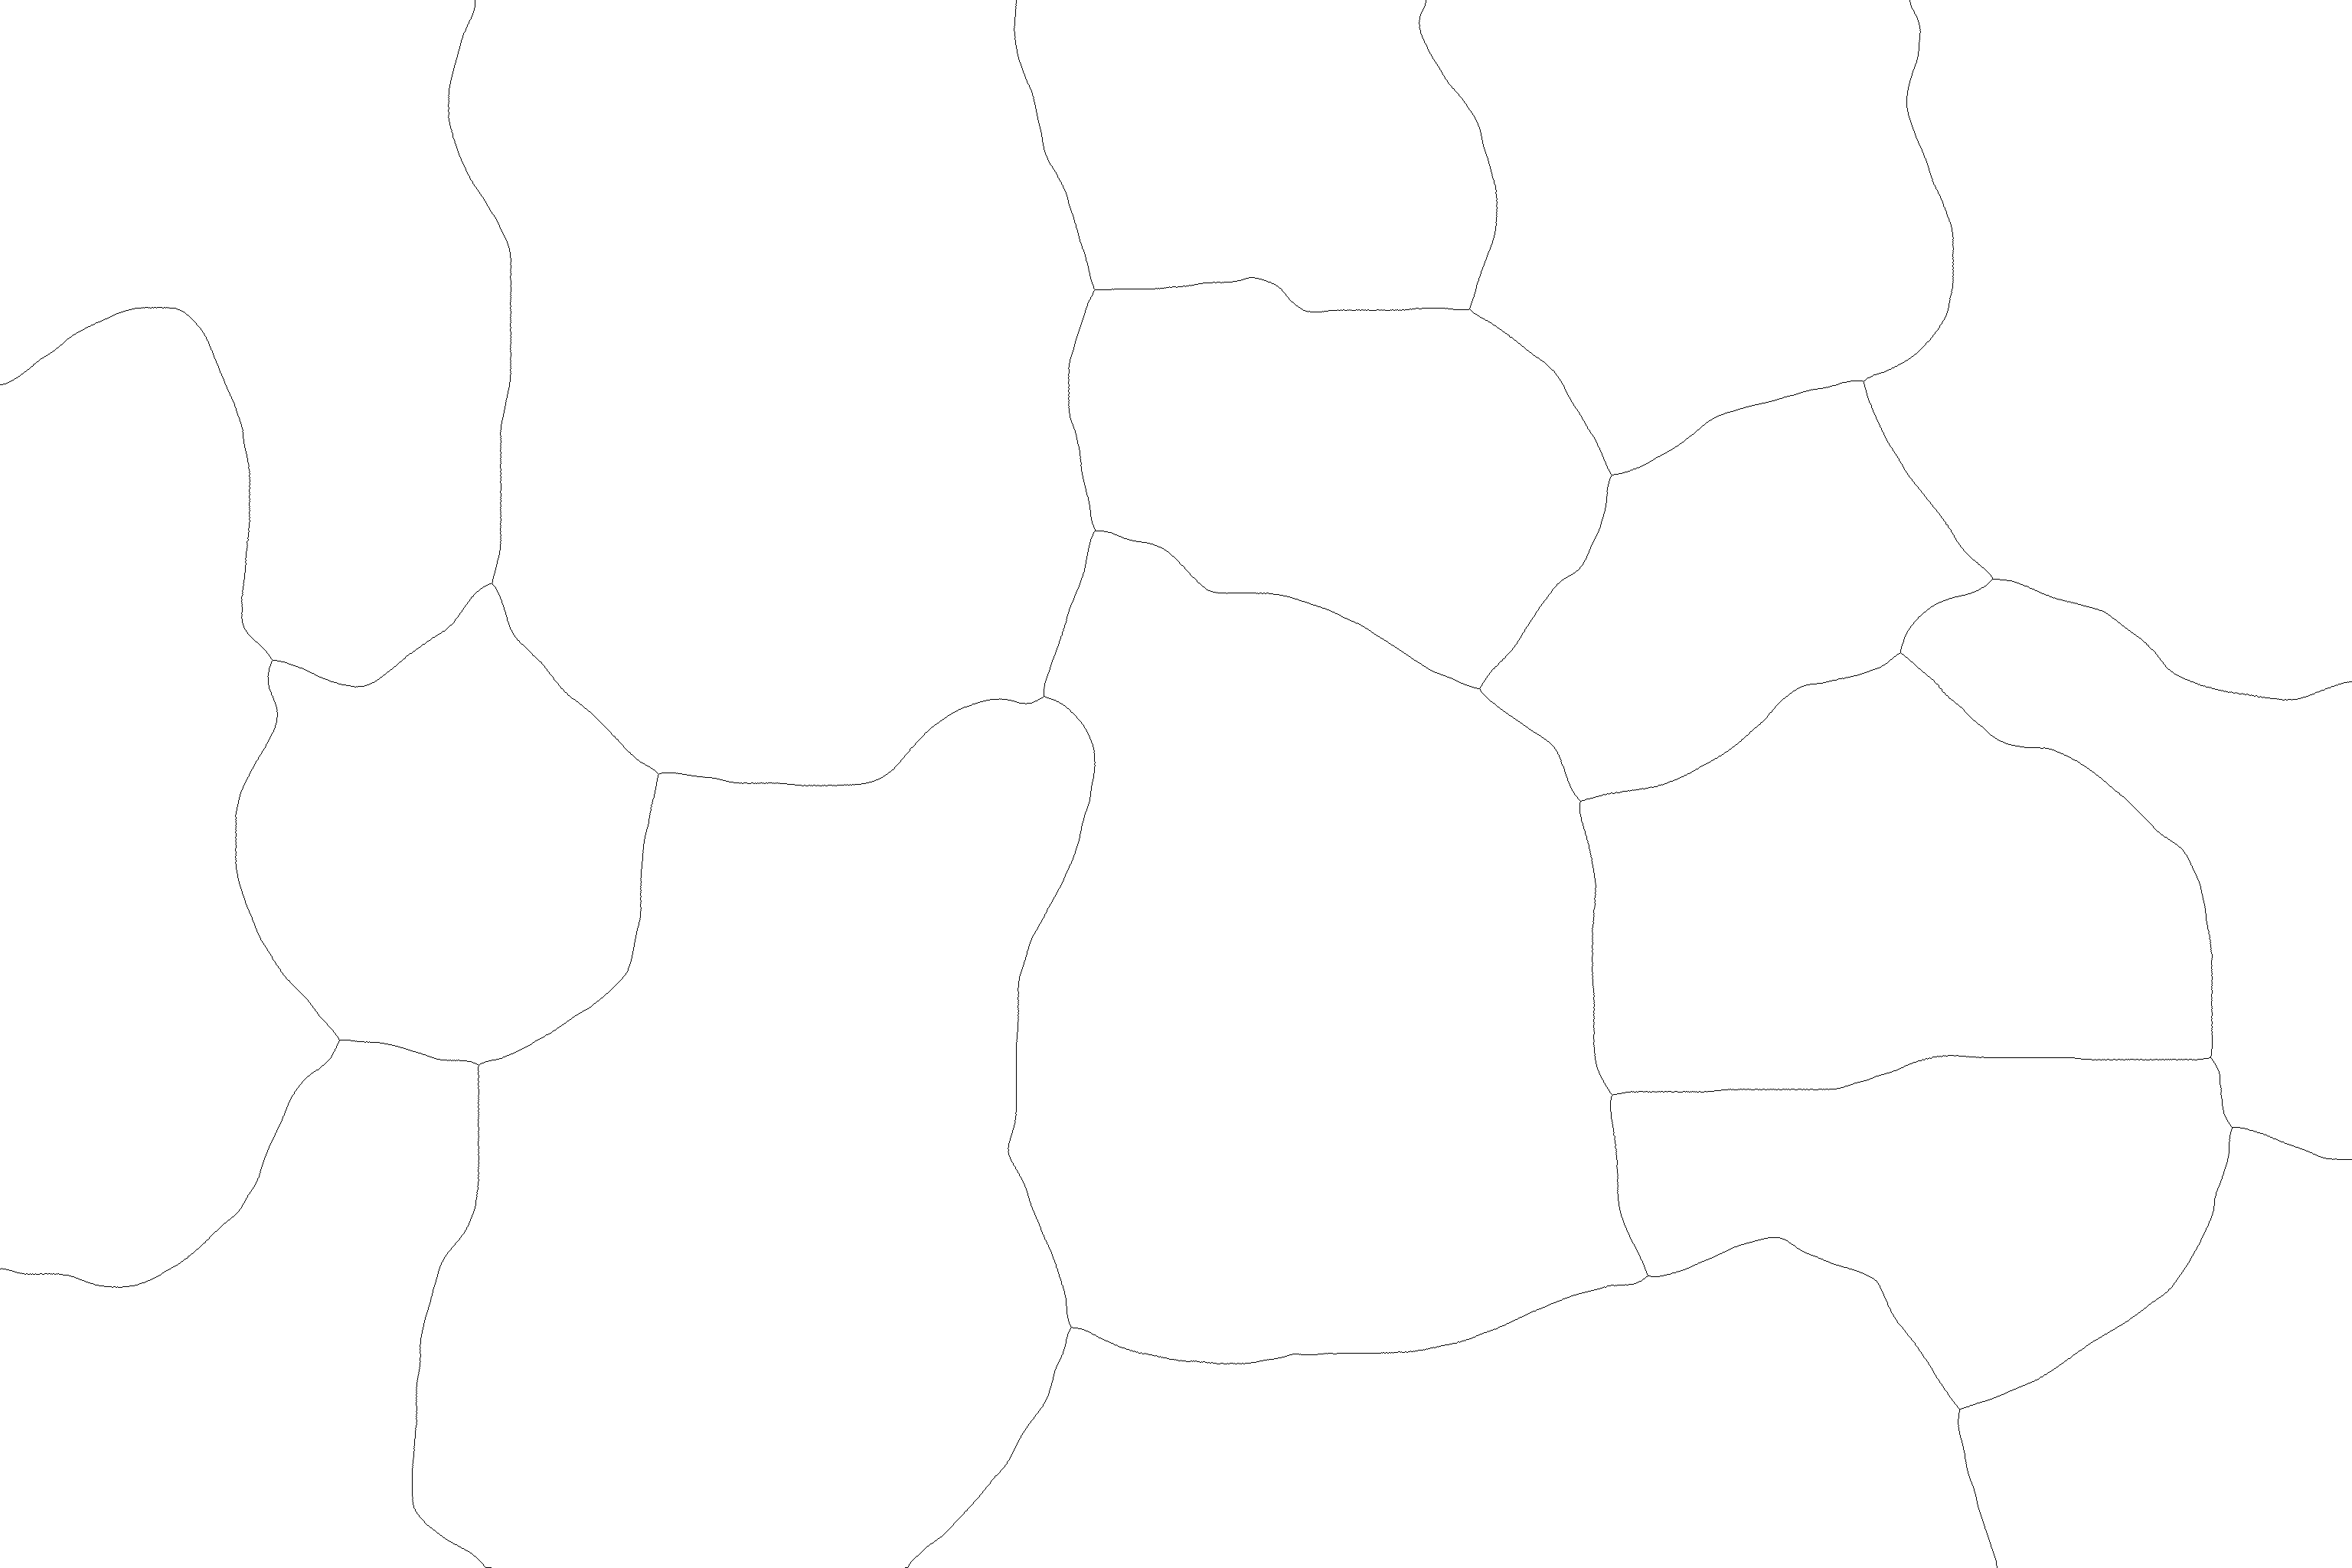

In [6]:
useBlur = True

if useBlur:
    # Blur ( a gaussian blur can be used to smooth the image and improve the skeletonization process )
    skeletonInput = imgp.gaussianBlur(gray, (55, 55), False)
else :
    skeletonInput = imgp.imreadGrayNormalized(imgPath, imgSize)

# Skeleton
sensitivity = 0.25
skeleton = imgp.skeletonize(skeletonInput, sensitivity, True)
ut.saveBinaryImage(getPath("skeleton.png"), skeleton)

17


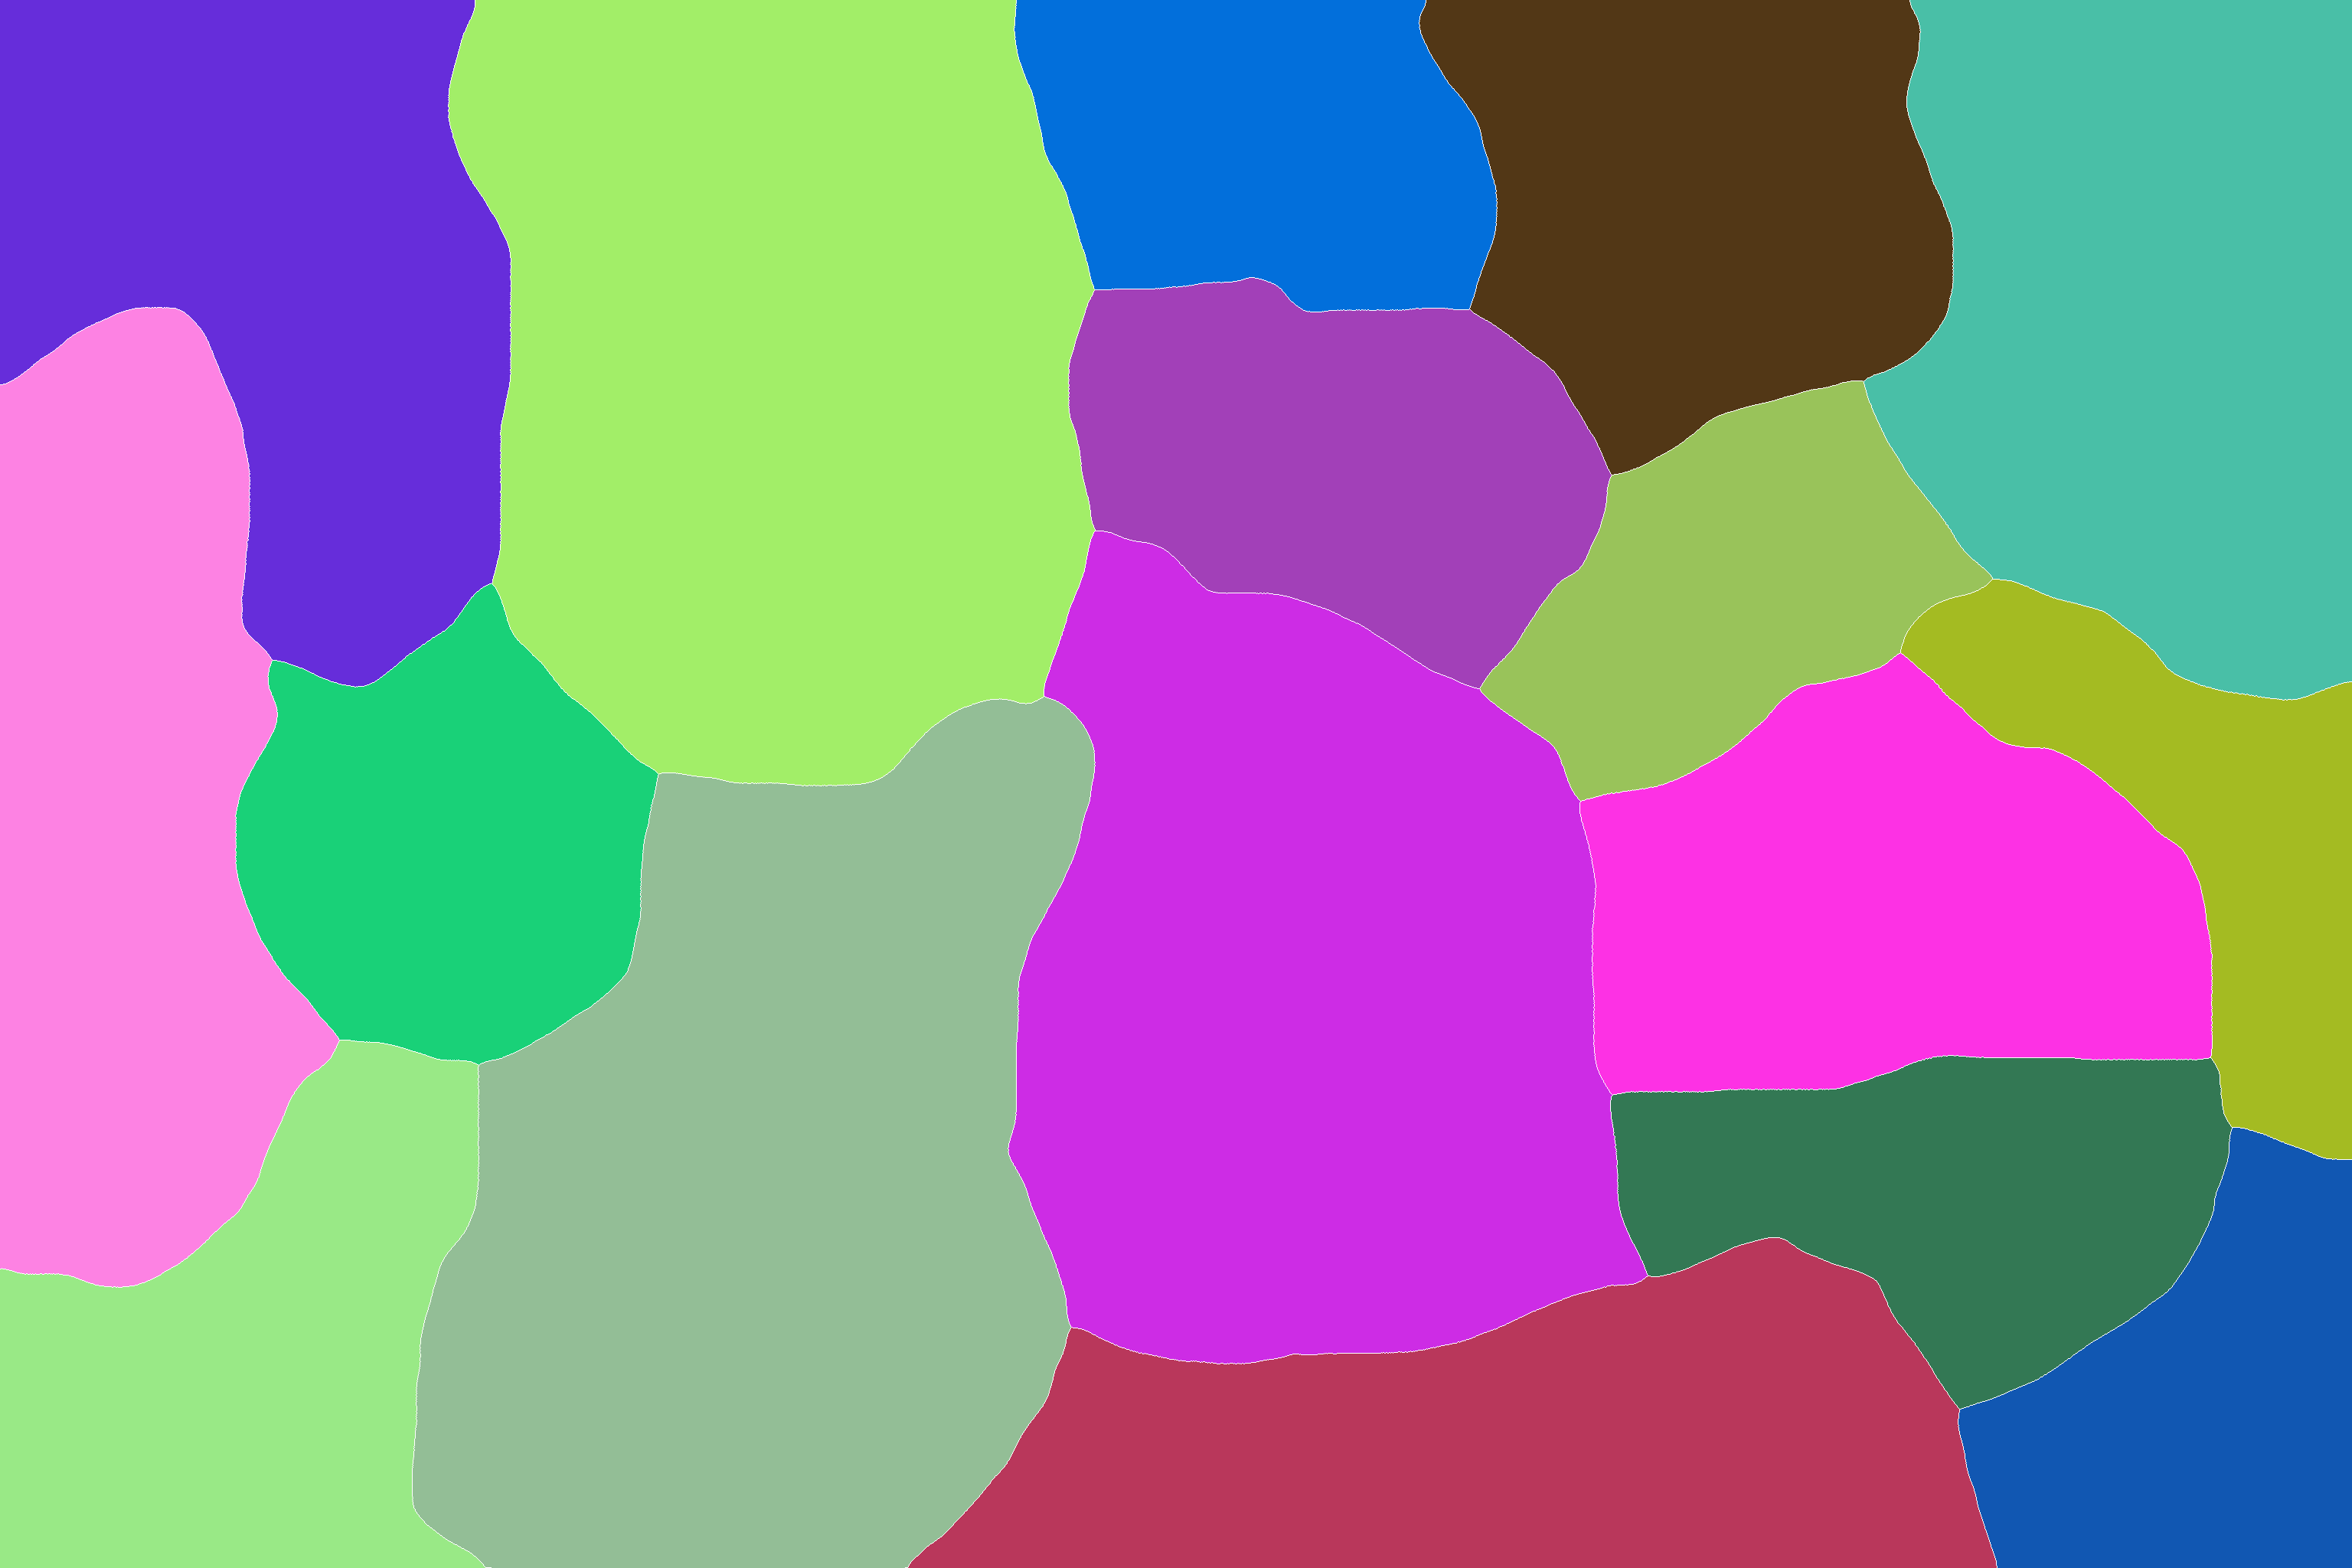

In [7]:
# Get contours
contours, points = imgp.getContours(gray, grayThreshold)
print(len(contours))

# Draw contours
filled_image = imgp.drawContours(skeleton, contours, False)

# Test filling
imgp.fillContours(skeleton, filled_image, points, True)

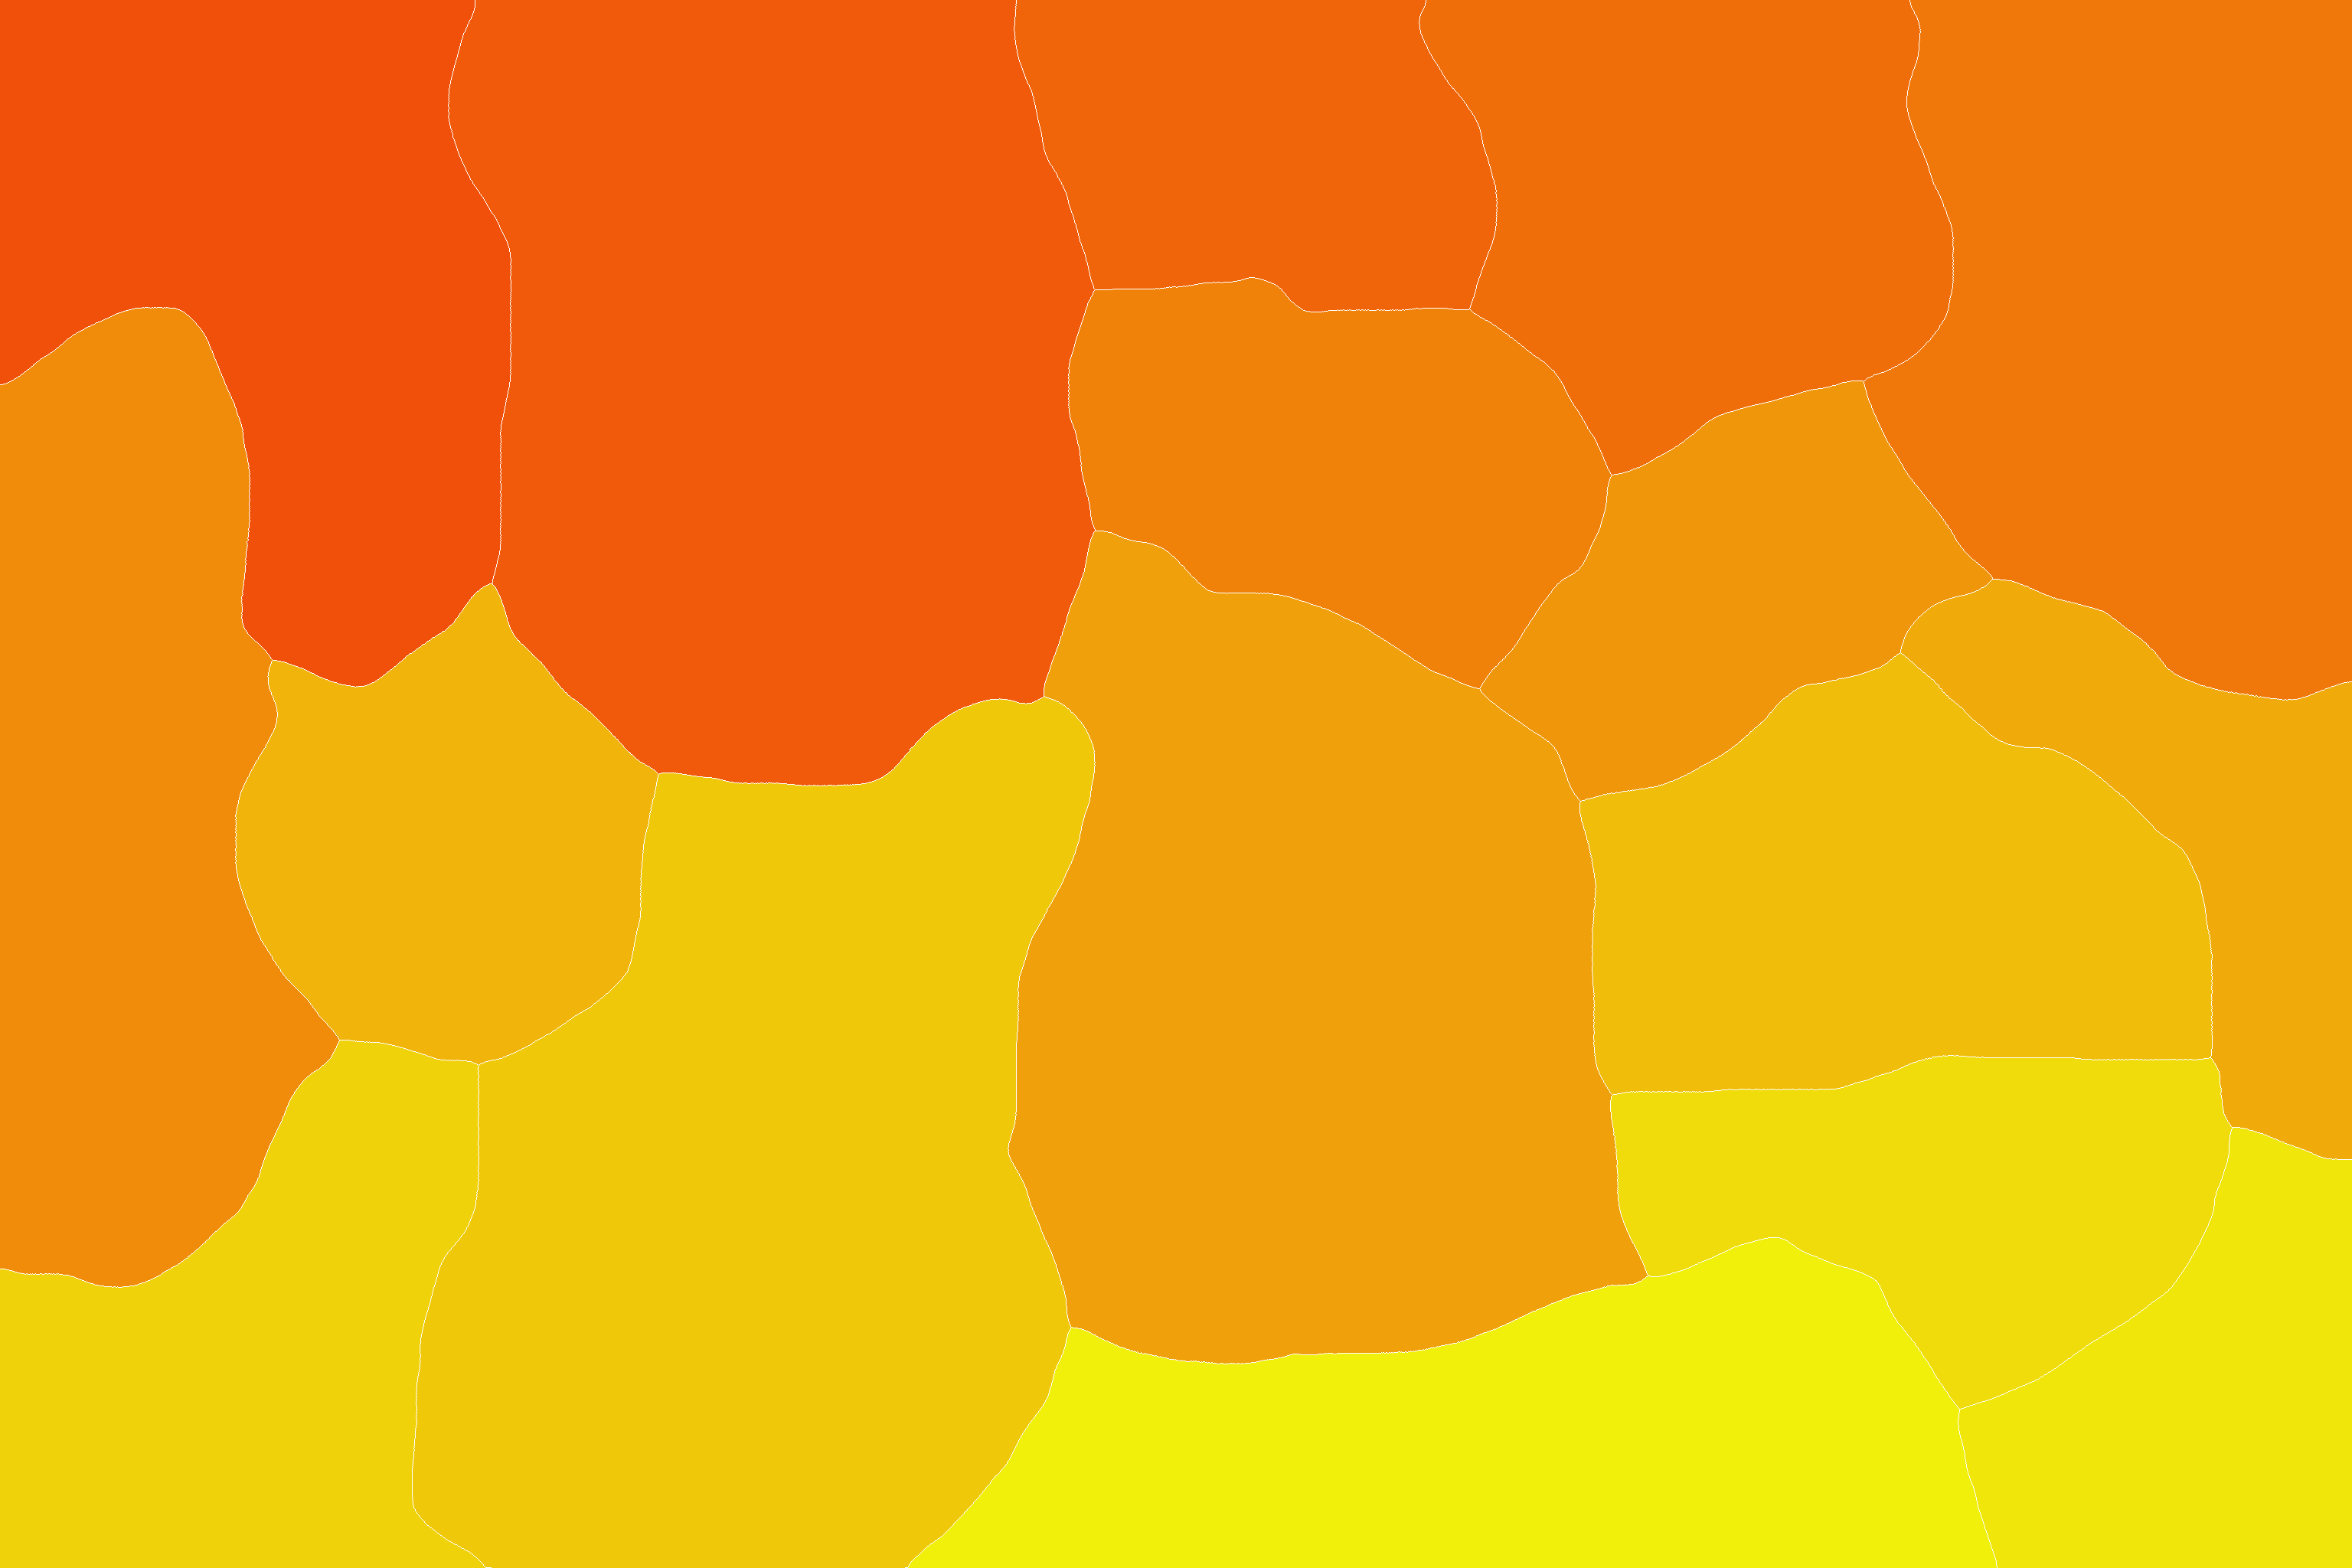

In [8]:
provinceDataViews, mapColors, mapDebug = mapp.doMapQuantization(
    skeleton, points, True, False)

cv2.imwrite(getPath("map_colors.png"),
            cv2.cvtColor(mapColors, cv2.COLOR_BGR2RGB))

if mapDebug is not None:    
    cv2.imwrite(getPath("map_colors_debug.png"),
                cv2.cvtColor(mapDebug, cv2.COLOR_BGR2RGB))

In [9]:
# CREATING JSON
data = mapp.createMapJson(
    projectName, 10, provinceDataViews, width+1024, height+1024)
ut.writeJson(data, outputPath, projectName)

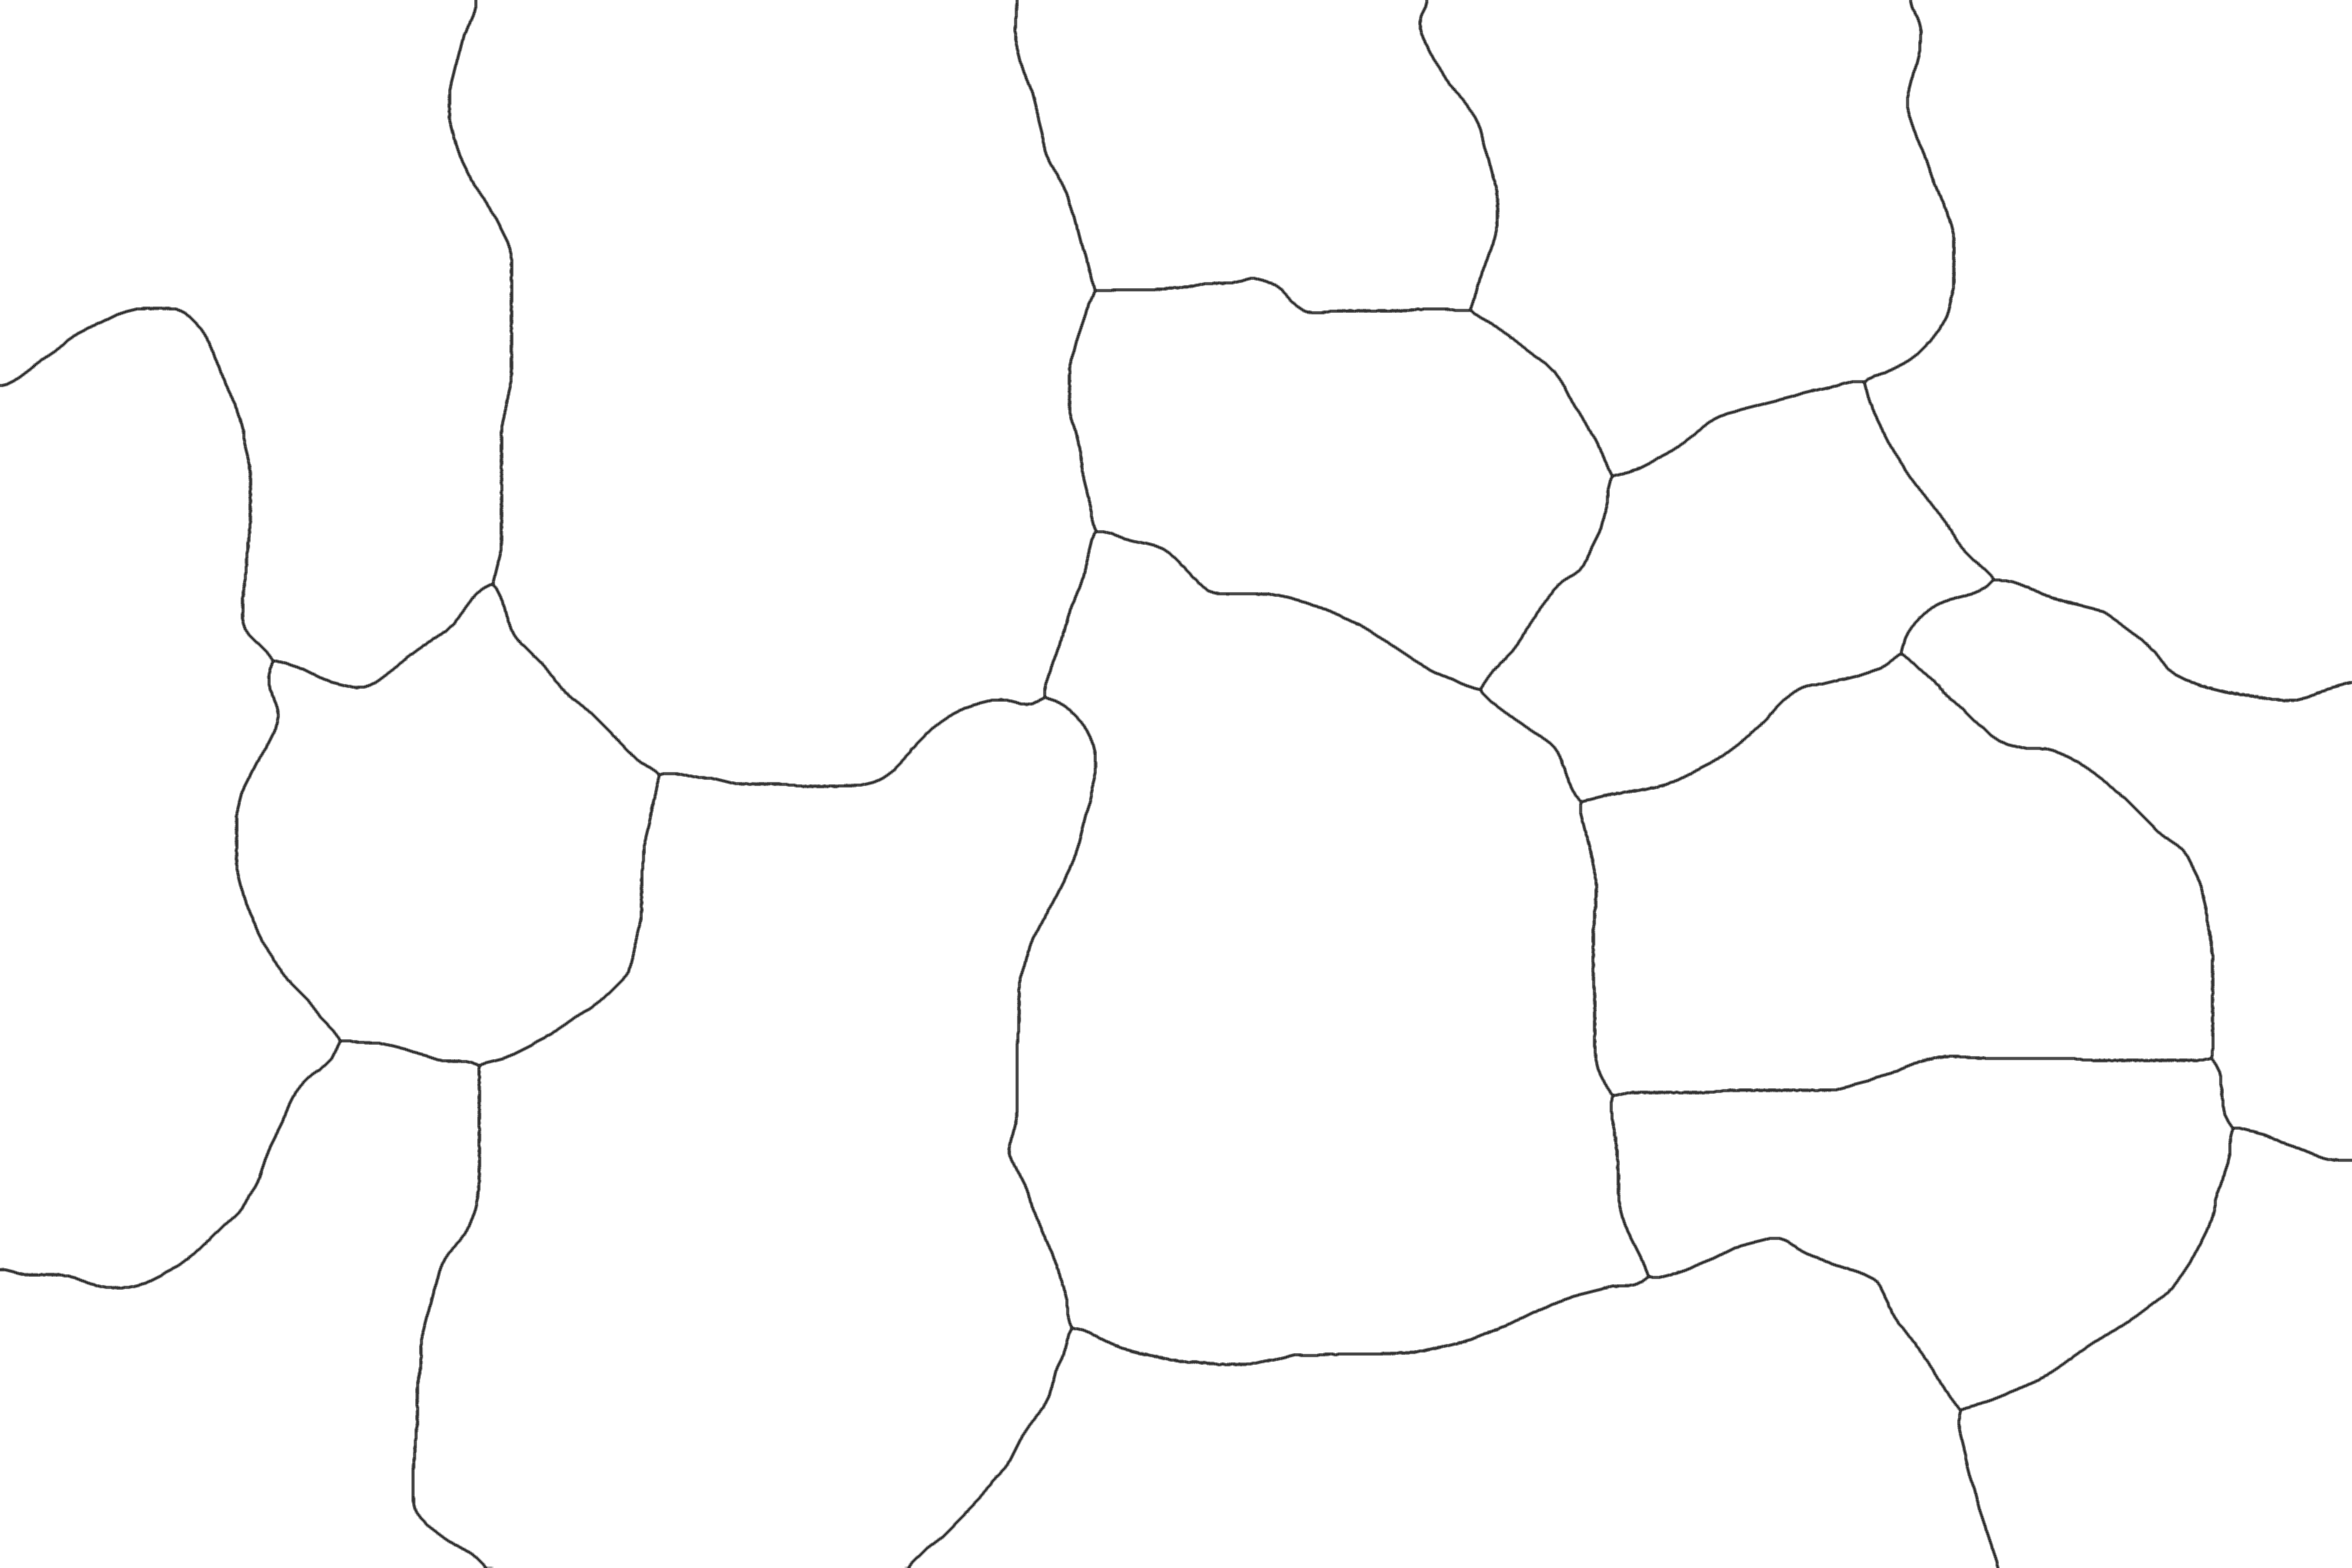

In [19]:
# CREATING BORDERS
invertedSkeleton = invert(skeleton)
color = imgp.hex_to_rgba("#333333")
mapBorders = imgp.thickening(
    invertedSkeleton, 2, 4, 80, color, True, False)
ut.saveCVImage(outputPath, 'map_borders.png',
               mapBorders)


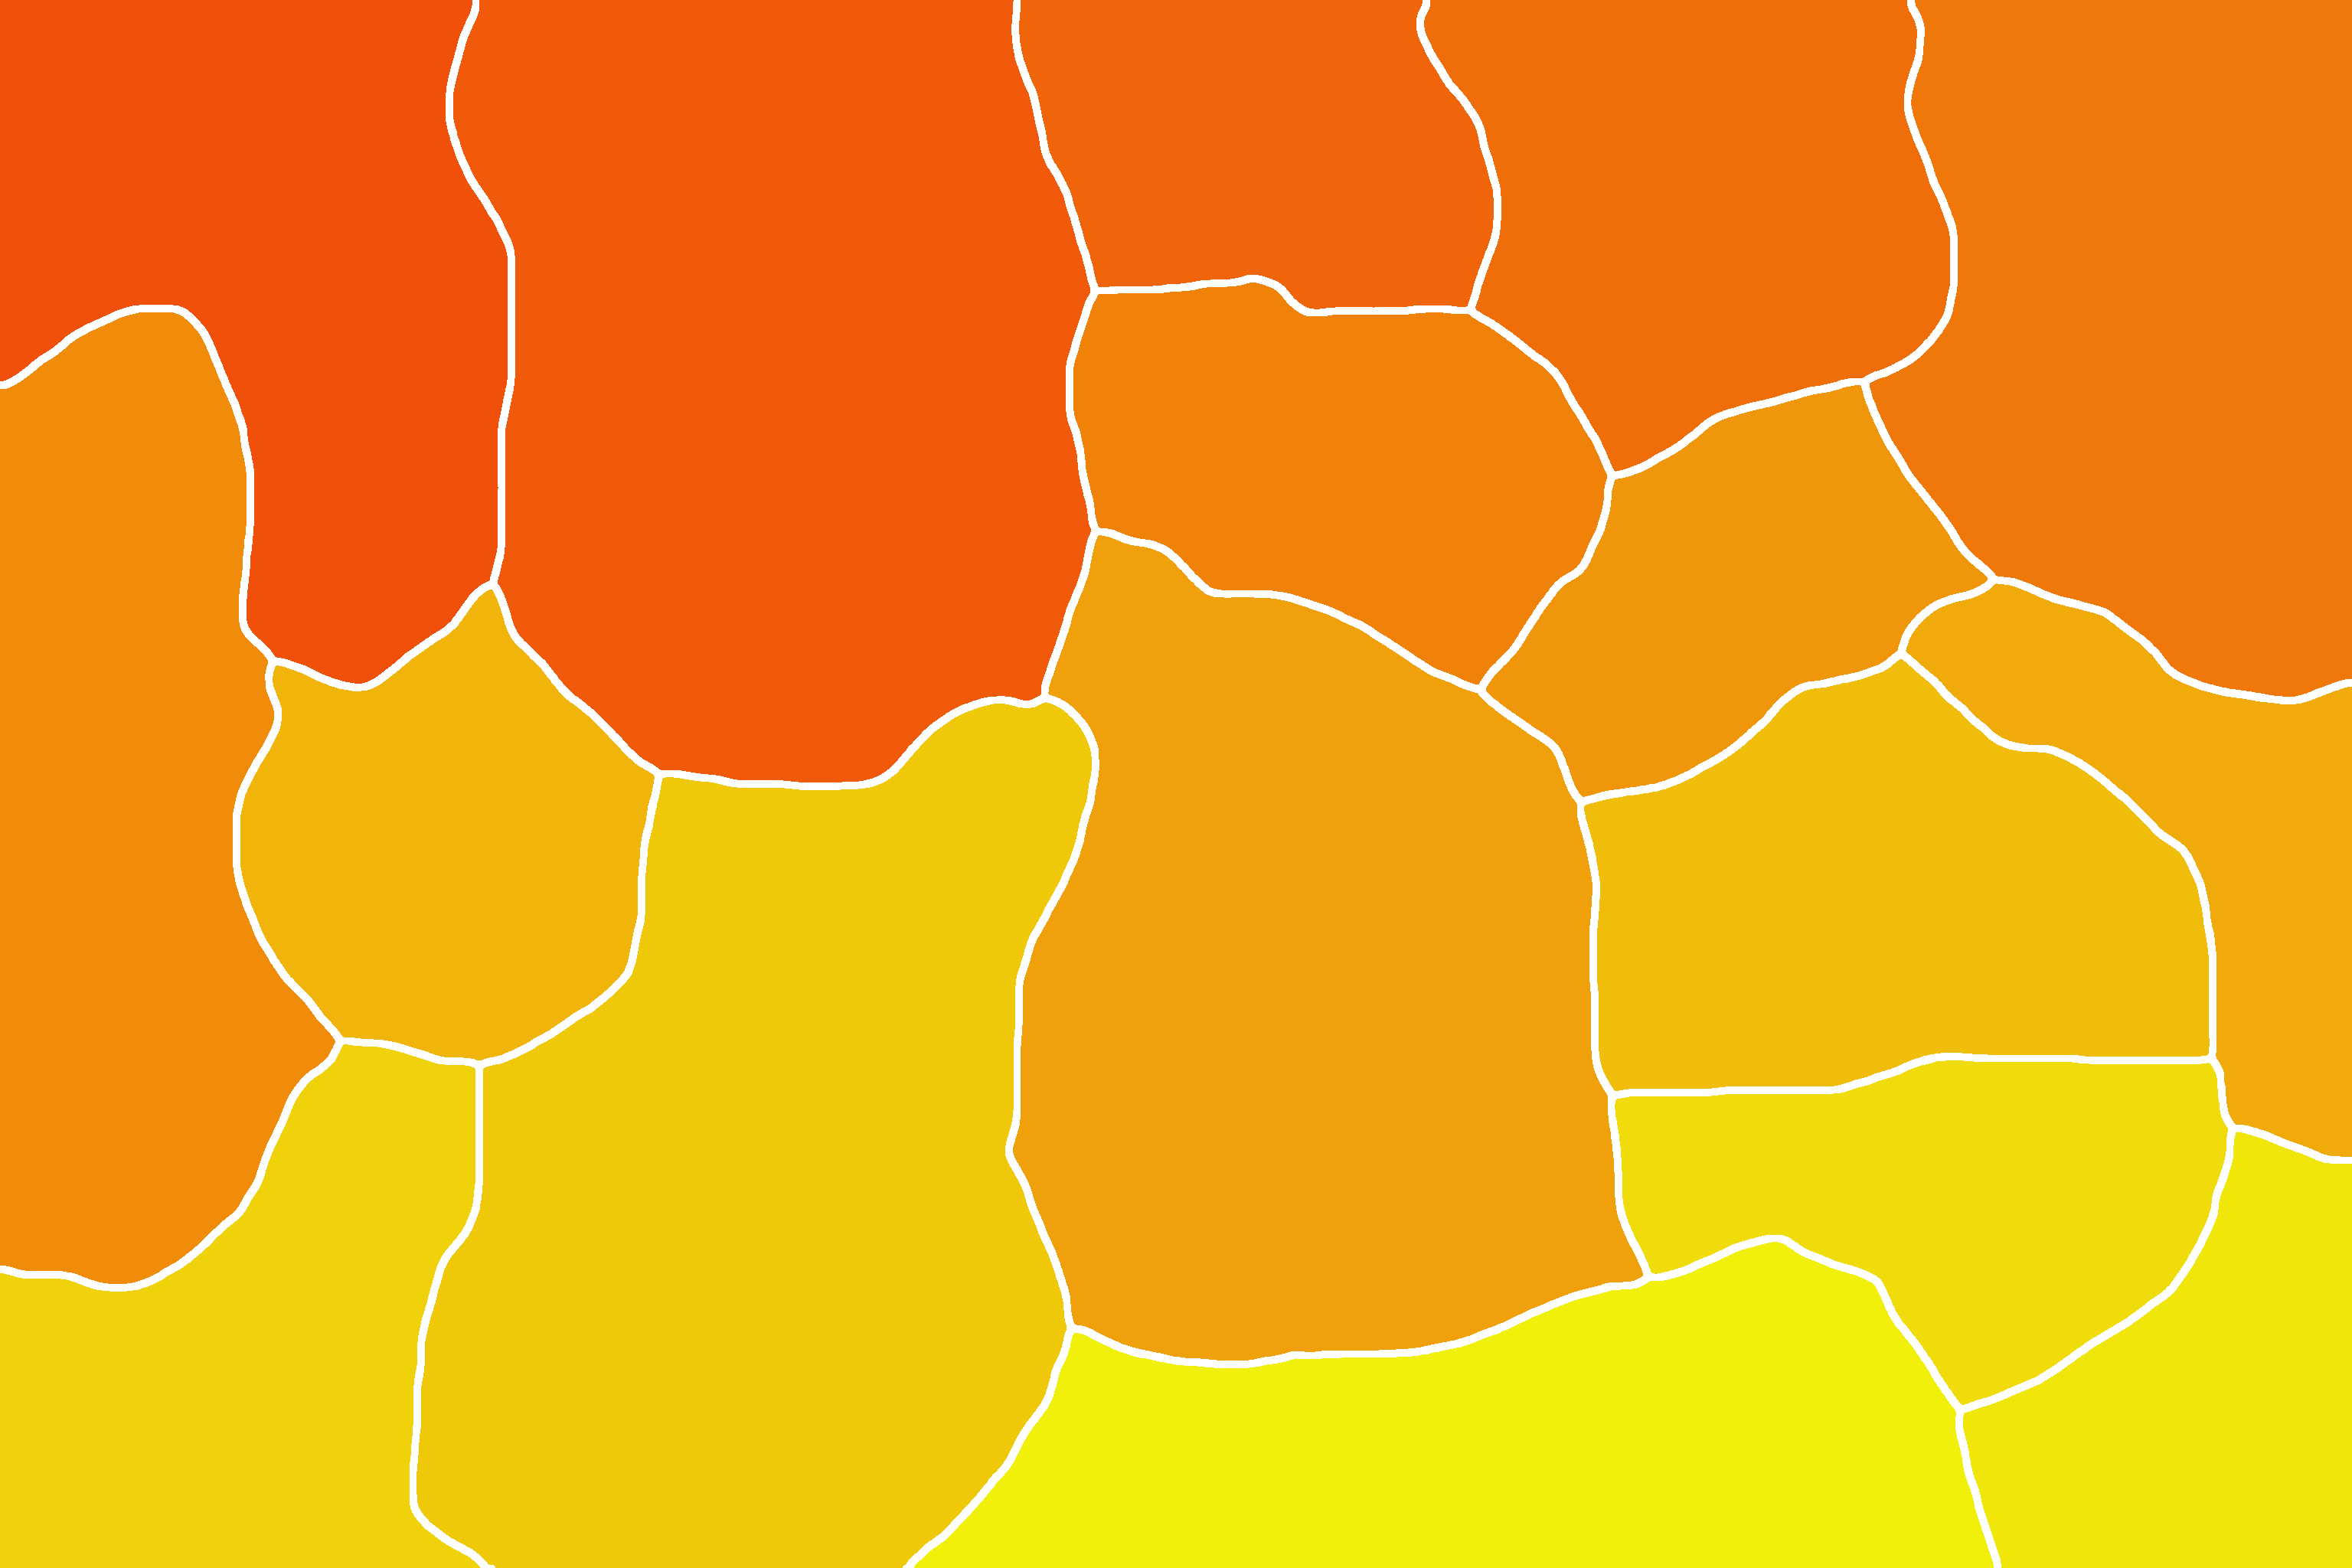

In [17]:
# Generate glow map
glowInput = cv2.cvtColor(mapColors, cv2.COLOR_RGB2RGBA)
mapGlow = imgp.alphaSubstractionWithThreshold(glowInput, mapBorders, threshold=60, display=True)
ut.saveCVImage(outputPath, 'map_glow.png', mapGlow)

In [18]:
# Generate debug map
mask = imgp.createBlankImage(width, height, (60, 20, 90, 255))
ut.saveCVImage(outputPath, 'map_debug.png', mask)